# 1. Import libraries

In [91]:
import keras
from numpy import asarray
from numpy import zeros
from keras.utils.np_utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
import re
import csv
import pandas
import numpy as np
from tensorflow.contrib import rnn
import tensorflow as tf
import matplotlib.pyplot as plt

In [92]:
np.set_printoptions(8, suppress=True)
#These options determine the way floating point numbers, arrays and other NumPy objects are displayed.
# 8 in first param indicates - Number of digits of precision for floating point output (default 8).
# suppressbool, optional:-
# If True, always print floating point numbers using fixed point notation, in which case numbers equal to zero in the current precision will print as zero. If False, then scientific notation is used when absolute value of the smallest number is < 1e-4 or the ratio of the maximum absolute value to the minimum is > 1e3. The default is False.

%matplotlib inline
#%matplotlib inline sets the backend of matplotlib to the 'inline' backend.

# 2. Data Import and Preprocessing

# 2.1 Loading train data

In [95]:
#Loading train data
train_file = 'data/train.csv'
train_corpus = pandas.read_csv(train_file, encoding='latin1').to_numpy()

print(train_corpus.shape)

(7613, 5)


In [12]:
#Head of train data to verify
train_corpus[:5]

array([[1, nan, nan,
        'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
        1],
       [4, nan, nan, 'Forest fire near La Ronge Sask. Canada', 1],
       [5, nan, nan,
        "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
        1],
       [6, nan, nan,
        '13,000 people receive #wildfires evacuation orders in California ',
        1],
       [7, nan, nan,
        'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ',
        1]], dtype=object)

In [16]:
#Tail of the train data to verify
train_corpus[-5:]

array([[10869, nan, nan,
        'Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5',
        1],
       [10870, nan, nan,
        '@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.',
        1],
       [10871, nan, nan,
        'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ',
        1],
       [10872, nan, nan,
        'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.',
        1],
       [10873, nan, nan,
        'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d',
        1]], dtype=object)

In [18]:
train_label = train_corpus[:,4] #target value (y=0 /1)
train_text = train_corpus[:,3] #id,keyword,location,text

# 2.2 Removing hyperlinks from Train data

In [19]:
#As we observed in the head and tail of the train data, we see there are many hyperlinks in between the data.
#So to simplify our process, we want to remove the hyperlinks from the data
for idx, tweet in enumerate(train_text):
    train_text[idx] = re.sub(r"http\S+", "", tweet)

In [21]:
#Verifying that the hyperlinks are removed.
train_corpus[-5:]

array([[10869, nan, nan,
        'Two giant cranes holding a bridge collapse into nearby homes ',
        1],
       [10870, nan, nan,
        '@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.',
        1],
       [10871, nan, nan, 'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. ',
        1],
       [10872, nan, nan,
        'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.',
        1],
       [10873, nan, nan,
        'The Latest: More Homes Razed by Northern California Wildfire - ABC News ',
        1]], dtype=object)

In [29]:
np.info(train_corpus)

class:  ndarray
shape:  (7613, 5)
strides:  (8, 60904)
itemsize:  8
aligned:  True
contiguous:  False
fortran:  True
data pointer: 0x1a4a3ab000
byteorder:  little
byteswap:  False
type: object


# 2.3 Loading test data

In [46]:
#Loading test data
test_file = 'data/test.csv'
test_corpus = pandas.read_csv(test_file, encoding='latin1').to_numpy()

print(test_corpus.shape)

(3263, 4)


In [47]:
#Head of test data to verify
test_corpus[:5]

array([[0, nan, nan, 'Just happened a terrible car crash'],
       [2, nan, nan,
        'Heard about #earthquake is different cities, stay safe everyone.'],
       [3, nan, nan,
        'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all'],
       [9, nan, nan, 'Apocalypse lighting. #Spokane #wildfires'],
       [11, nan, nan, 'Typhoon Soudelor kills 28 in China and Taiwan']],
      dtype=object)

In [48]:
#Tail of the test data to verify
test_corpus[-5:]

array([[10861, nan, nan,
        'EARTHQUAKE SAFETY LOS ANGELES Â\x89Ã\x9bÃ\x92 SAFETY FASTENERS XrWn'],
       [10865, nan, nan,
        'Storm in RI worse than last hurricane. My city&amp;3others hardest hit. My yard looks like it was bombed. Around 20000K still without power'],
       [10868, nan, nan,
        'Green Line derailment in Chicago http://t.co/UtbXLcBIuY'],
       [10874, nan, nan,
        'MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3'],
       [10875, nan, nan,
        '#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm']],
      dtype=object)

In [49]:
test_label = np.zeros((3263, 1), dtype=int) #Since this is what is missing and we need to predict, we are initiating it with zeroes
test_text = test_corpus[:,3] #id,keyword,location,text (all the given four attributes)

# 2.4 Removing hyperlinks from Test data


In [50]:
# Remove hyperlinks from strings

for idx, tweet in enumerate(test_text):
    test_text[idx] = re.sub(r"http\S+", "", tweet)

In [51]:
np.info(test_corpus)

class:  ndarray
shape:  (3263, 4)
strides:  (8, 26104)
itemsize:  8
aligned:  True
contiguous:  False
fortran:  True
data pointer: 0x13f311000
byteorder:  little
byteswap:  False
type: object


# 2.5. One-Hot encoding of label

In [52]:
from keras.utils.np_utils import to_categorical

# One-hot encode
train_targets = train_label
encoded_train_targets = to_categorical(train_targets)
print(encoded_train_targets)

[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [53]:
labels = encoded_train_targets

In [54]:
labels

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [ ]:
#Defining inputs

training_docs = train_text #training 
test_docs = test_text #test

# 2.6 Building a reverse encoder 

In [55]:
def inverseEncoding(encoded):
    ans = np.zeros(encoded.shape[0])
    for idx, vector in enumerate(encoded):
        ans[idx] = np.argmax(vector)
    return ans

print(inverseEncoding(encoded_train_targets))

[1. 1. 1. ... 1. 1. 1.]


# 2.7: Tokenizer - Text pre-processing with Keras

In [63]:
#Document Tokenization
#Use Keras library to create a vector of words for every tweet.
#These vectors are padded up to 50, which can be the limit of number of words possible in a 150 character tweet.

# Prepare tokenizer (t for training set, tt for test set)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


#Constructing Tokenizer class
t = Tokenizer() #Tokenizer class constructor for training documents
tt = Tokenizer() #Tokenizer class constructor for testing documents


#Fitting Tokenizer to the documents
t.fit_on_texts(training_docs) 
tt.fit_on_texts(test_docs)


# Integer encode the documents
encoded_docs = t.texts_to_sequences(training_docs)
encoded_test_docs = tt.texts_to_sequences(test_docs)


# Pad documents to a max length of 50 words (150 characters, 3 characters a word (including space))
max_length = 50
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
padded_test_docs = pad_sequences(encoded_test_docs, maxlen=max_length, padding='post')

In [82]:
# encoded_docs
# encoded_test_docs

In [69]:
vocab_size = len(t.word_index) + 1
test_vocab_size = len(tt.word_index) + 1
print("The training set vocab size is "+ str(vocab_size))
print("\nThe test set vocab size is "+ str(test_vocab_size))


The training set vocab size is 18099

The test set vocab size is 10784


In [89]:
# Learn about the training data through tokenizer
# print(t.word_counts)
# print(t.document_count)
# print(t.word_index)
# print(t.word_docs)

In [90]:
# Learn about the testing data through tokenizer
# print(tt.word_counts)
# print(tt.document_count)
# print(tt.word_index)
# print(tt.word_docs)

# 3. Develop a model for the data

# 3.1 Word Embeddings - NLP

In [96]:
# Word Embedding

#The GLoVe link: https://nlp.stanford.edu/projects/glove/

embeddings_index = dict()
embeddings_index

{}

In [97]:
#For the embedding matrix we use GloVe’s 50d word vector pre-trained on 2 billion tweets. 

f = open('glove/glove.twitter.27B.50d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

f.close()


print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193514 word vectors.


In [98]:
# create a weight matrix for words in training docs

embedding_matrix = zeros((vocab_size, 50))

for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    

In [ ]:
# create a weight matrix for words in test docs

test_embedding_matrix = zeros((vocab_size, 50))

for word, j in tt.word_index.items():
    test_embedding_vector = embeddings_index.get(word)
    if test_embedding_vector is not None:
        test_embedding_matrix[j] = test_embedding_vector
            

In [99]:
embedding_matrix_transpose = embedding_matrix.transpose()
test_embedding_matrix_transpose = test_embedding_matrix.transpose()

# 3.2 Design the Neural Network 

# 3.2.1 Defining constants

In [103]:
#The number of classes is 2 (Disaster or not)

n_classes = 2

In [104]:
#Time_steps in max. number of words per each tweet i.e., 50

time_steps = max_length

In [105]:
#50 dimension for Glove words

n_input = 50 

In [106]:
# Hidden LSTM units = batch_size
# Batch size is = num_units = 128

num_units = 128
batch_size = 128

In [107]:
#learning rate for adam

learning_rate=0.001

# 3.2.2 Choosing weights and biases

In [110]:
out_weights=tf.Variable(tf.random_normal([num_units,n_classes]))

out_bias=tf.Variable(tf.random_normal([n_classes]))

# 3.2.3 Defining Placeholders

In [111]:
#input image placeholder

x = tf.placeholder(tf.float32,[None, time_steps, n_input])

In [112]:
#input label placeholder

y = tf.placeholder(tf.float32,[None, n_classes])

# 3.2.4 Processing the input tensor from [batch_size,n_steps,n_input] to "time_steps" number of [batch_size,n_input] tensors

In [113]:
input=tf.unstack(x ,time_steps,1)

# 3.2.5 Recurrent Neural Networks - LSTM

In [116]:
#defining the RNN

lstm_layer=rnn.BasicLSTMCell(num_units,forget_bias=1)

outputs,_=rnn.static_rnn(lstm_layer,input,dtype="float32")

# 3.2.6 out_weight multiplication

In [118]:
#converting last output of dimension [batch_size,num_units] to [batch_size,n_classes] by out_weight multiplication
#prediction = output of last LSTM time step x weights + bias

prediction = tf.matmul(outputs[-1],out_weights)+out_bias

# 3.2.7 softmax for probability


In [119]:
#softmax for probability

prob = tf.nn.softmax(prediction)

# 3.2.8 Defining Loss function

For convinience purpose, we chose cross entropy as our logistic loss instead of implementing log loss.

In [124]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y))

# 3.2.9 Construct the Adam optimizer

In [130]:
#Defining learning_rate for the Adam optimizer

learning_rate = 0.001


#Defining optimizer 

opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

# 3.2.10 Model Evaluation

In [131]:
#probability = softmax(prediction)


correct_prediction = tf.equal(tf.argmax(prediction,1),tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

# 3.2.11 Defining next_batch and change_shape

In [133]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

def change_shape(data,embedding_matrix_transpose):
    '''
    Change shape to batch_x=batch_x.reshape((batch_size,time_steps,n_input))
    '''
    data1 = zeros((batch_size, time_steps, n_input))
    for x in range(0, num_units):
        for y in range(0, time_steps): 
            #print (data[x,y], embedding_matrix(data[x,y]))
            #print (embedding_matrix[data[x,y]])
            for z in range(0,n_input):
                data1[x][y][z]= embedding_matrix_transpose[z,data[x,y]]
    #print(data1)
    return(data1)
                

# 3.2.12 Initilializing variables

In [161]:
probabilities = np.zeros((test_label.size, 2))

losses = np.zeros(199)

accuracies = np.zeros(199)


# 3.2.13 Session init

In [162]:
init=tf.global_variables_initializer()

# 3.2.13 Running iterations

In [182]:
with tf.Session() as sess:
    sess.run(init)
    iter=1
    index=0
    while iter<800:
        
        #batch_x,batch_y=mnist.train.next_batch(batch_size=batch_size)
        
        # use embedding matrix and one hot for batch_x
        
        batch_x, batch_y = next_batch(batch_size, padded_docs, labels)
        batch_x= change_shape(batch_x, embedding_matrix_transpose)
        sess.run(opt, feed_dict={x: batch_x, y: batch_y})

        if iter %10==0:
            acc=sess.run(accuracy,feed_dict={x:batch_x,y:batch_y})
            los=sess.run(loss,feed_dict={x:batch_x,y:batch_y})
            accuracies[index] = acc
            losses[index] = los
            index=index+1
            print("For iter ",iter)
            print("Accuracy ",acc)
            print("Loss ",los)
            print("__________________")

        iter=iter+1
        
    print("Optimization finished!")
    
    
    
    #calculating test accuracy
    
    # all test labels are 0
    
    test_data = padded_test_docs
    
    '''
    Change shape to test_data=test_data.reshape((3263,time_steps,n_input))
    '''
    test_data1 = zeros((3263, time_steps, n_input))
    for a in range(0, 3263):
        for b in range(0, time_steps): 
            for c in range(0,n_input):
                test_data1[a][b][c]= test_embedding_matrix_transpose[c,test_data[a,b]]
    
    probabilities = sess.run(prob, feed_dict={x: test_data1})

For iter  10
Accuracy  0.7265625
Loss  0.5850975
__________________
For iter  20
Accuracy  0.7578125
Loss  0.50462794
__________________
For iter  30
Accuracy  0.78125
Loss  0.46926573
__________________
For iter  40
Accuracy  0.7734375
Loss  0.49391916
__________________
For iter  50
Accuracy  0.8515625
Loss  0.359805
__________________
For iter  60
Accuracy  0.8515625
Loss  0.36717752
__________________
For iter  70
Accuracy  0.8046875
Loss  0.40621462
__________________
For iter  80
Accuracy  0.859375
Loss  0.4064924
__________________
For iter  90
Accuracy  0.8203125
Loss  0.4290954
__________________
For iter  100
Accuracy  0.7421875
Loss  0.45640153
__________________
For iter  110
Accuracy  0.75
Loss  0.5070728
__________________
For iter  120
Accuracy  0.828125
Loss  0.36271718
__________________
For iter  130
Accuracy  0.796875
Loss  0.40669942
__________________
For iter  140
Accuracy  0.859375
Loss  0.49050006
__________________
For iter  150
Accuracy  0.8046875
Loss  0.4159

# 3.2.14 Recording the predicted probabilities

In [174]:
    print("Testing Probabilities")
    print("0\t 1")
    print(probabilities)
    probabilities.shape

Testing Probabilities
0	 1
[[0.0001166  0.9998834 ]
 [0.00007213 0.9999279 ]
 [0.00010095 0.999899  ]
 ...
 [0.00008019 0.9999198 ]
 [0.59100145 0.40899855]
 [0.65550053 0.34449953]]


(3263, 2)

In [175]:
idx = np.arange(test_label.size, dtype=np.int16)
idx.shape
out = np.rec.fromarrays((idx, probabilities[:,0], probabilities[:,1]),  names = ('i','D','ND'))
print(out)

[(   0, 0.0001166 , 0.9998834 ) (   1, 0.00007213, 0.9999279 )
 (   2, 0.00010095, 0.999899  ) ... (3260, 0.00008019, 0.9999198 )
 (3261, 0.59100145, 0.40899855) (3262, 0.65550053, 0.34449953)]


In [176]:
idx = np.arange(test_label.size, dtype=np.int16)
idx.shape
results = np.rec.fromarrays((test_corpus[:,0], np.where(probabilities[:,1]>0.5, 1, 0)),  names = ('id','target'))
print(results)

[(0, 1) (2, 1) (3, 1) ... (10868, 1) (10874, 0) (10875, 0)]


In [177]:
with open('results.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_NONE)
    wr.writerow(('id','target'))
    wr.writerows(results)

In [178]:
iterations.shape

(199,)

In [179]:
losses.shape

(199,)

In [180]:
accuracies.shape

(199,)

# 4. Results

# 4.1) Training Log Loss with iterations

# a. Training Log Loss with iterations - Iterations 2000

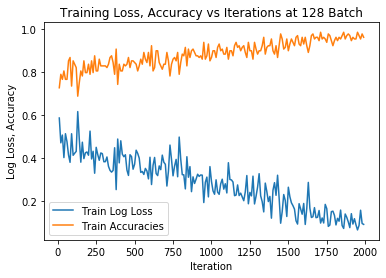

In [181]:
iterations = np.arange(start=10, stop=2000, step=10, dtype=np.int16)
# Plot Loss and Accuracy vs iterations
plt.plot( iterations, losses )
plt.plot( iterations, accuracies )
plt.legend(['Train Log Loss', 'Train Accuracies'])
plt.ylabel('Log Loss, Accuracy')
plt.xlabel('Iteration')
plt.title('Training Loss, Accuracy vs Iterations at 128 Batch')
plt.show()

In [ ]:
# b. raining Log Loss with iterations - Iterations 800

In [ ]:
iterations = np.arange(start=10, stop=2000, step=10, dtype=np.int16)
# Plot Loss and Accuracy vs iterations
plt.plot( iterations, losses )
plt.plot( iterations, accuracies )
plt.legend(['Train Log Loss', 'Train Accuracies'])
plt.ylabel('Log Loss, Accuracy')
plt.xlabel('Iteration')
plt.title('Training Loss, Accuracy vs Iterations at 128 Batch')
plt.show()

# 4.2) Kaggle Score vs Optimization iterations

In [191]:
rowheader = ['Kaggle Score']
kaggle_score = np.array([0.68813, 0.81492, 0.75971, 0.80674])
headings = ['LSTM-200', 'LSTM-800', 'LSTM-2000', 'LSTM-2500']
pandas.DataFrame([kaggle_score], rowheader, headings )

,LSTM-200,LSTM-800,LSTM-2000,LSTM-2500
Kaggle Score,0.68813,0.81492,0.75971,0.80674


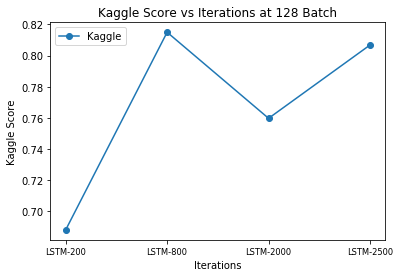

In [192]:
# Plot Private and Public vs iterations
plt.plot( range(len(kaggle_score)), kaggle_score, '-o' )

plt.xticks(range(len(kaggle_score)), headings, size='small')

plt.legend(['Kaggle'])
plt.ylabel('Kaggle Score')
plt.xlabel('Iterations')
plt.title('Kaggle Score vs Iterations at 128 Batch')
plt.show()

# 4.3) Test Scores vs Batch Size

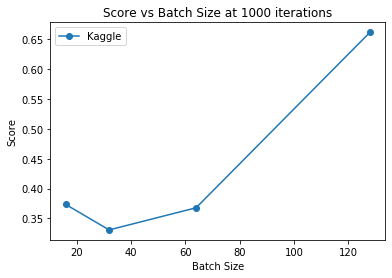

In [190]:
b_kaggle_score = np.array([0.37334, 0.33058, 0.36772, 0.66201])

b_sizes = np.array([16, 32, 64, 128])
plt.plot( b_sizes, b_kaggle_score, '-o' )

plt.legend(['Kaggle'])
plt.ylabel('Score')

plt.xlabel('Batch Size')
plt.title('Score vs Batch Size at 1000 iterations')
plt.show()